In [200]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import odeint

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [333]:
folder = 'TDE'
is_tde = True
snap = '210'
m = 5
beta = 2
path = f'{folder}/{snap}'
G = 1
Mbh = 10**m
Rt = Mbh**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2


In [317]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Mass, Den, Press, Temp = make_tree(path, snap, is_tde, energy = False)

R = np.sqrt(X**2 + Y**2 + Z**2)
V = np.sqrt(VX**2 + VY**2 + VZ**2)
dim_cell = Vol**(1/3) # according to Elad
time, tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m=m, choose = 'tfb')

days after disruption: 3.456952163743516, t_fall: 12.649110640673518


Function for orbits

In [318]:
def sort_list(list1, list2):
 
    zipped_pairs = zip(list2, list1)
 
    z = [x for _, x in sorted(zipped_pairs)]
 
    return np.array(z)

In [319]:
def to_cylindric(x,y):
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    radius = np.sqrt(x**2+y**2)
    return radius, theta_coord

def from_cylindric(theta, r):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def keplerian_orbit(theta, a, ecc = 0.999):
    p = 2 * a
    radius = p / (1 + ecc * np.cos(theta))
    return radius

def normal_plane(x_data, y_data, dim_data, theta_chosen):
    if np.abs(theta_chosen - np.pi/2) < 0.1: # if theta is close to pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data > 0)
    elif np.abs(theta_chosen + np.pi/2) < 0.1: # if theta is close to -pi/2
        condition_coord = np.abs(x_data) < dim_data  # vertical line
        condition_coord = np.logical_and(condition_coord, y_data < 0)
    else:
        m = np.tan(theta_chosen)
        condition_coord = np.abs(y_data - m * x_data) < dim_data
        if np.logical_and(theta_chosen > 0, theta_chosen != np.pi): # if theta is in the first or second quadrant
            condition_coord = np.logical_and(condition_coord, y_data > 0)
        elif theta_chosen == 0:
            condition_coord = np.logical_and(condition_coord, x_data >= 0)
        elif theta_chosen == np.pi:
            condition_coord = np.logical_and(condition_coord, x_data >= 0)
        else:
            condition_coord = np.logical_and(condition_coord, y_data < 0)
    return condition_coord

def avg_consecutive_triplets(array, i, choose):
    if choose == 'before':
        triplet = array[i-3:i+1]
    else:
        triplet = array[i:i+3+1]
    avg = sum(triplet) / 3

    if choose == 'before':
        return avg, i-3
    else: 
        return avg, i+3

def find_width(x_mid, y_mid, dim_mid, den_mid, theta_cm):
    threshold = 1/3
    # find the normal plane 
    condition_coord = normal_plane(x_mid, y_mid, dim_mid, theta_cm)
    x_plane = x_mid[condition_coord]
    y_plane = y_mid[condition_coord]
    r_plane = np.sqrt(x_plane**2 + y_plane**2)
    den_plane = den_mid[condition_coord]
    # sort 
    r_plane = list(r_plane)
    x_plane_sorted = sort_list(x_plane, r_plane)
    y_plane_sorted = sort_list(y_plane, r_plane)
    den_plane_sorted = sort_list(den_plane, r_plane)

    # find the cm of the plane
    idx_cm = np.argmax(den_plane_sorted)    
    x_cm = x_plane_sorted[idx_cm]
    y_cm = y_plane_sorted[idx_cm]
    den_cm = den_plane_sorted[idx_cm]
    
    # walk before and after the cm till you find a density 3 times smaller
    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > threshold * den_cm and idx_step > 0:
        idx_step -= 1
        den_tube = den_plane_sorted[idx_step]
    idx_before = idx_step+1
    x_low = x_plane_sorted[idx_before]
    y_low = y_plane_sorted[idx_before]
    den_low = den_tube

    idx_step = idx_cm
    den_tube = den_cm
    while den_tube > threshold * den_cm and idx_step < len(den_plane_sorted) - 1:
        idx_step += 1
        den_tube  = den_plane_sorted[idx_step]
    idx_after = idx_step-1
    x_high = x_plane_sorted[idx_after]
    y_high = y_plane_sorted[idx_after]
    den_high = den_tube
    
    return x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high

def find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr):
    cm = np.zeros((3,len(theta_arr)))
    upper_tube = np.zeros((3,len(theta_arr)))
    lower_tube = np.zeros((3,len(theta_arr)))
    for i,theta in enumerate(theta_arr):
        x_cm, y_cm, den_cm, x_low, y_low, den_low, x_high, y_high, den_high = find_width(x_mid, y_mid, dim_mid, den_mid, theta)
        cm[0][i], cm[1][i], cm[2][i] = x_cm, y_cm, den_cm
        lower_tube[0][i], lower_tube[1][i], lower_tube[2][i] = x_low, y_low, den_low
        upper_tube[0][i], upper_tube[1][i], upper_tube[2][i] = x_high, y_high, den_high
    
    return cm, upper_tube, lower_tube

def find_streams(x_mid, y_mid, dim_mid, den_mid, theta_arr):
    # first run to find the maxima (1 for every theta in theta_arr!). NB: the could be on different streams
    cm, upper_tube, lower_tube = find_width_stream(x_mid, y_mid, dim_mid, den_mid, theta_arr) 
    second_cm = []
    for i in range(len(cm[0])): #cm has 3 rows and len(theta_arr) columns
        #find again the normal plane
        condition_coord = normal_plane(x_mid, y_mid, dim_mid, theta_arr[i])
        x_norm = x_mid[condition_coord]
        y_norm = y_mid[condition_coord]
        r_norm = np.sqrt(x_norm**2 + y_norm**2)

        den_norm = den_mid[condition_coord]
        x_upper = upper_tube[0][i]
        y_upper = upper_tube[1][i]
        r_upper = np.sqrt(x_upper**2 + y_upper**2)
        x_lower = lower_tube[0][i]
        y_lower = lower_tube[1][i]
        r_lower = np.sqrt(x_lower**2 + y_lower**2)

        cond_rlow = np.logical_and(r_norm > R0, r_norm < r_lower)
        x_second = x_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        y_second = y_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        den_second = den_norm[np.logical_or(cond_rlow, r_norm > r_upper)]
        idx_cm2 = np.argmax(den_second)
        if den_second[idx_cm2] > cm[2][i]/3:
            second_cm.append([x_second[idx_cm2], y_second[idx_cm2], den_second[idx_cm2]])
    # broadcast as cm
    second_cm = np.transpose(second_cm)
    return cm, second_cm


In [320]:
def solvr(Y, theta):
    L = 1
    y0 = Y[1]
    y1 =  -Y[0] + G * Mbh / ((1 - Rs**Y[0]) * L**2)
    return [y0, y1]

In [321]:
a_theta = np.arange(-np.pi/2, np.pi/2, 0.01)
asol = odeint(solvr, [0, 1e4], a_theta)
print(asol)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1570796326795D+01   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.1560796326795D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.1570796326795D+01   r2 = -0.1570796326795D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.1550796326795D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.1570796326795D+01   r2 = -0.1570796326795D+01
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 = -0.1550796326795D+01
[[ 0.00000000e+000  1.00000000e+004]
 [             nan              nan]
 [             nan              nan]
 [-2.20516291e+304 -1.24214635e+304]
 [             nan  3.54546378

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_29807/645924924.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  y1 =  -Y[0] + G * Mbh / ((1 - Rs**Y[0]) * L**2)


In [322]:
# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2

# Parabolic orbit
theta_arr_kep = np.arange(0, 2*np.pi, 0.01)
orbit = keplerian_orbit(theta_arr_kep, a = Rp)
x_orbit, y_orbit = from_cylindric(theta_arr_kep, orbit) 

Midplane 

In [323]:
# take wanted data
midplane = np.abs(Z) < dim_cell

X_cross = X[midplane]
Y_cross = Y[midplane]
VX_cross = VX[midplane]
VY_cross = VY[midplane]
Vol_cross = Vol[midplane]
dim_cross = dim_cell[midplane]
Temp_cross = Temp[midplane]
Den_cross = Den[midplane]
Mass_cross   = Mass[midplane]

In [324]:
theta_lim = 3/4*np.pi
theta_arr = np.concatenate((np.arange(theta_lim, 0, -0.02), np.arange(0, -theta_lim, -0.02))) #0.01 as the epsilon in the find_sz plane function

In [325]:
cm, upper_tube, lower_tube  = find_width_stream(X_cross, Y_cross, dim_cross, Den_cross, theta_arr)

Text(0, 0.5, 'Y [$R_\\odot$]')

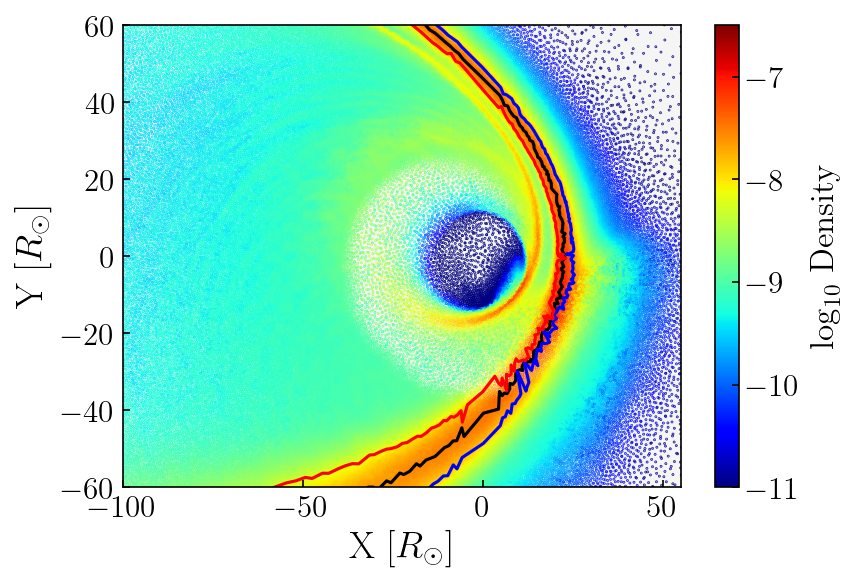

In [326]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'jet', vmin = -11, vmax = -6.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.plot(cm[0], cm[1], c = 'k')
ax.plot(upper_tube[0], upper_tube[1],  c = 'b')
ax.plot(lower_tube[0], lower_tube[1],  c = 'r')
ax.set_xlim(-100,55)
ax.set_ylim(-60,60)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

Text(0, 0.5, 'Width [$R_\\odot$]')

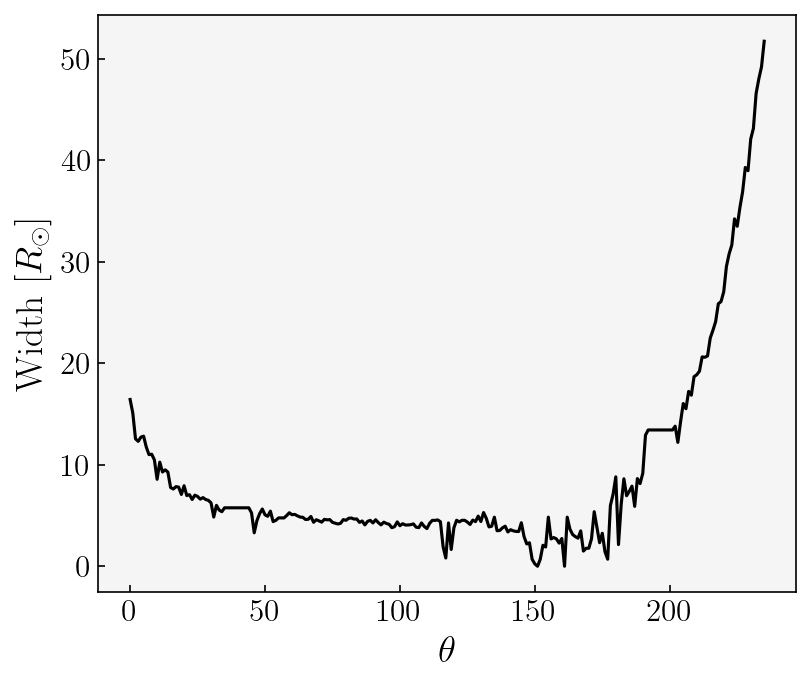

In [327]:
r_upper = np.sqrt(upper_tube[0]**2 + upper_tube[1]**2)
r_lower = np.sqrt(lower_tube[0]**2 + lower_tube[1]**2)
width = r_upper - r_lower
plt.figure(figsize=(6,5))
plt.plot(width, c = 'k')
plt.xlabel(r'$\theta$', fontsize = 18)
plt.ylabel(r'Width [$R_\odot$]', fontsize = 18)

In [328]:
first_cm, second_cm = find_streams(X_cross, Y_cross, dim_cross, Den_cross, theta_arr)

(-60.0, 60.0)

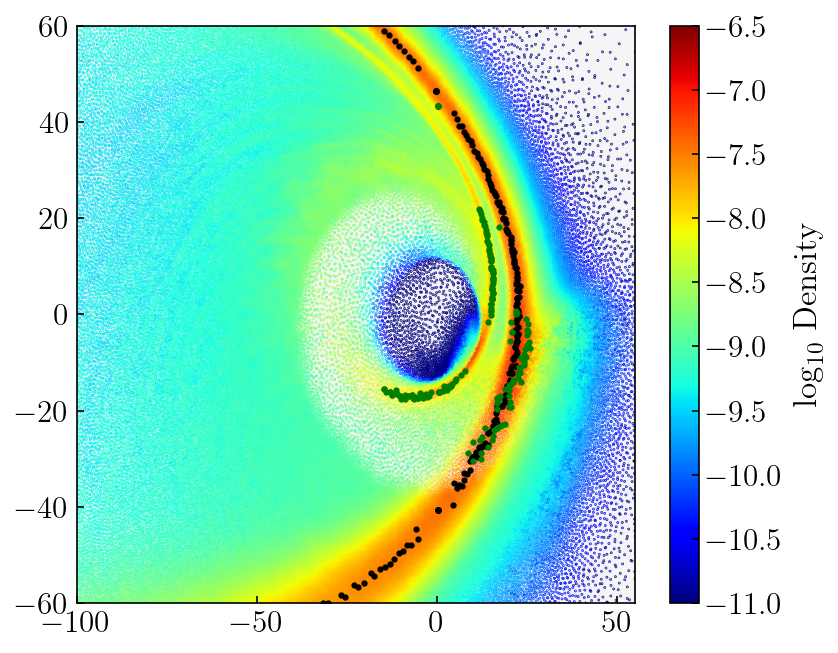

In [329]:
fig, ax = plt.subplots(1,1, figsize = (6,5))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'jet', vmin = -11, vmax = -6.5)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.scatter(first_cm[0], first_cm[1], s = 4, c = 'k')
ax.scatter(second_cm[0], second_cm[1], s = 4, c = 'green')
ax.set_xlim(-100,55)
ax.set_ylim(-60,60)

Stone13

In [330]:
def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 

In [331]:
z_arr = np.arange(-1, 1, 0.2)
free_fall = []
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_arr)
    free_fall.append(z)

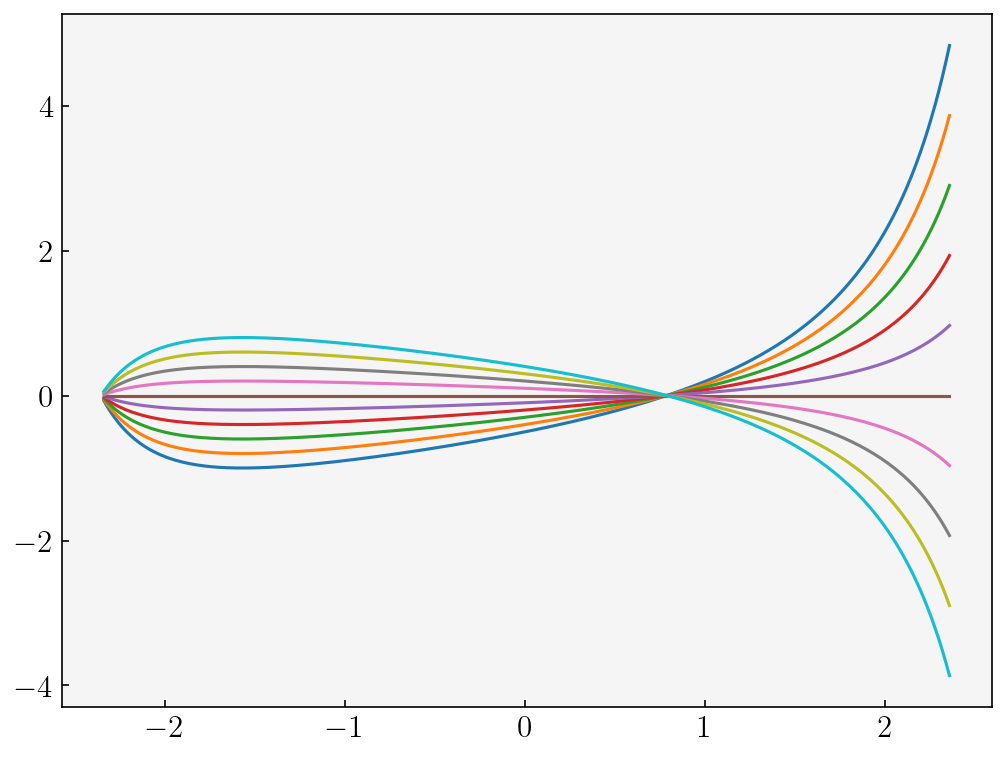

In [332]:
for i in range(len(z_arr)):
    plt.plot(theta_arr, free_fall[i])